# End to End Matching Example

Please run [Record-Linkage-Example.ipynb](Record-Linkage-Example.ipynb) before this one in order to get the trained model at `../trained-models/notebooks/rl/rl-model.ckpt`.

## Boilerplate

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from importlib import reload
import logging
reload(logging)
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.INFO, datefmt='%H:%M:%S')

In [3]:
import sys

sys.path.insert(0, '..')

In [4]:
import entity_embed

In [5]:
import torch
import numpy as np

random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)

## Loading Test Data

In [6]:
import json
from ordered_set import OrderedSet

def load_pair_set(filepath):
    with open(filepath, 'r') as f:
        test_pos_pair_set = json.load(f)
        return OrderedSet(tuple(pair) for pair in test_pos_pair_set)

train_pos_pair_set = load_pair_set('../trained-models/notebooks/rl/rl-train-pos-pairs.json')
valid_pos_pair_set = load_pair_set('../trained-models/notebooks/rl/rl-valid-pos-pairs.json')
test_pos_pair_set = load_pair_set('../trained-models/notebooks/rl/rl-test-pos-pairs.json')

In [7]:
import json

def load_record_dict(filepath):
    with open(filepath, 'r') as f:
        record_dict = json.load(f)
        return {int(id_): record for id_, record in record_dict.items()}

train_record_dict = load_record_dict('../trained-models/notebooks/rl/rl-train-records.json')
valid_record_dict = load_record_dict('../trained-models/notebooks/rl/rl-valid-records.json')
test_record_dict = load_record_dict('../trained-models/notebooks/rl/rl-test-records.json')

## Loading Model

In [8]:
from entity_embed import LinkageEmbed

model = LinkageEmbed.load_from_checkpoint('../trained-models/notebooks/rl/rl-model.ckpt')

## Blocking

Use `sim_threshold = 0.45` to have ~6k pairs in `train_found_pair_set` and have a fair comparison with [End-to-End-Matching-Baseline.ipynb](./End-to-End-Matching-Baseline.ipynb)

In [9]:
%%time

eval_batch_size = 64
ann_k = 100
sim_threshold = 0.45

train_found_pair_set, train_vector_dict = model.predict_pairs(
    record_dict=train_record_dict,
    batch_size=eval_batch_size,
    ann_k=ann_k,
    sim_threshold=sim_threshold,
    show_progress=True,
    return_vector_dict=True
)

# batch embedding:   0%|          | 0/44 [00:00<?, ?it/s]

CPU times: user 34.8 s, sys: 2.09 s, total: 36.8 s
Wall time: 6.98 s


In [10]:
%%time

valid_found_pair_set, valid_vector_dict = model.predict_pairs(
    record_dict=valid_record_dict,
    batch_size=eval_batch_size,
    ann_k=ann_k,
    sim_threshold=sim_threshold,
    show_progress=True,
    return_vector_dict=True
)

# batch embedding:   0%|          | 0/15 [00:00<?, ?it/s]

CPU times: user 9.76 s, sys: 326 ms, total: 10.1 s
Wall time: 1.99 s


In [11]:
%%time

test_found_pair_set, test_vector_dict = model.predict_pairs(
    record_dict=test_record_dict,
    batch_size=eval_batch_size,
    ann_k=ann_k,
    sim_threshold=sim_threshold,
    show_progress=True,
    return_vector_dict=True
)

# batch embedding:   0%|          | 0/15 [00:00<?, ?it/s]

CPU times: user 31 s, sys: 1.58 s, total: 32.6 s
Wall time: 8.95 s


In [12]:
from entity_embed.evaluation import pair_entity_ratio

pair_entity_ratio(len(test_found_pair_set), len(test_record_dict))

0.9008810572687225

In [13]:
from entity_embed.evaluation import precision_and_recall

precision_and_recall(test_found_pair_set, test_pos_pair_set)

(0.2995110024449878, 0.98)

Complement the train/valid `found_pair_set` with `pos_pair_set` for training.  
Leave test untoched, to reproduce production behavior:

In [14]:
train_found_pair_set |= train_pos_pair_set
valid_found_pair_set |= valid_pos_pair_set

## Matching: Compare

Make a dataframe `df` with all records (train, valid, test) to add additional features:

In [15]:
record_dict = {**train_record_dict, **valid_record_dict, **test_record_dict}

In [16]:
import pandas as pd

df = pd.DataFrame.from_dict(record_dict, orient='index')
df = df.drop(columns='id')

In [17]:
df['all'] = df.agg('{0[title]} - {0[description]} - {0[manufacturer]} - {0[price]}'.format, axis=1)
df['price'] = pd.to_numeric(df['price'].str.replace(' ', ''), errors='coerce')
df.head(3)

,description,manufacturer,price,title,__source,cluster,all
1728,system requirements macintosh macintosh comput...,,1149.00,filemaker pro 8 . 5 5 - user pack,google,1561,filemaker pro 8 . 5 5 - user pack - system req...
255,- marketing information: diskeeper pro premier...,diskeeper corporation,736.66,diskeeper 2007 pro premier 5 - lic pack,amazon,1207,diskeeper 2007 pro premier 5 - lic pack - - ma...
2889,,,16.00,emc securid appl mnt - ent / std 17mo per u 2k...,google,2231,emc securid appl mnt - ent / std 17mo per u 2k...


Replace all `record_dict`s (train, valid, test) to add additional features:

In [18]:
train_record_dict = df.loc[train_record_dict.keys()].to_dict(orient='index')
valid_record_dict = df.loc[valid_record_dict.keys()].to_dict(orient='index')
test_record_dict = df.loc[test_record_dict.keys()].to_dict(orient='index')

del df

In [19]:
import textdistance as td
import math

def exact_eq(x, y):
    return float(x == y)

def token_ops(func):
    def new_func(x, y):
        return func(x.split(), y.split())    
    return new_func

def abs_diff(x, y):
    return abs(x - y)

def abs_diff_log10(x, y):
    diff = abs_diff(x, y)
    if diff > 1:
        return math.log10(diff)
    else:
        return 0.0

SIM_FUNC_DICT = {
    ("all", "jaccard"): token_ops(td.jaccard.normalized_similarity),
    ("all", "overlap"): token_ops(td.overlap.normalized_similarity),
    ("all", "damerau_levenshtein"): td.damerau_levenshtein.normalized_similarity,
    ("all", "jaro_winkler"): td.jaro_winkler.normalized_similarity,
    ("manufacturer", "jaccard"): token_ops(td.jaccard.normalized_similarity),
    ("manufacturer", "overlap"): token_ops(td.overlap.normalized_similarity),
    ("manufacturer", "damerau_levenshtein"): td.damerau_levenshtein.normalized_similarity,
    ("manufacturer", "jaro_winkler"): td.jaro_winkler.normalized_similarity,
    ("title", "jaccard"): token_ops(td.jaccard.normalized_similarity),
    ("title", "overlap"): token_ops(td.overlap.normalized_similarity),
    ("title", "damerau_levenshtein"): td.damerau_levenshtein.normalized_similarity,
    ("title", "jaro_winkler"): td.jaro_winkler.normalized_similarity,
    ("price", "abs_diff"): abs_diff,
    ("price", "abs_diff_log10"): abs_diff_log10,
}

def record_sim_func(record_pair):
    record_left, record_right = record_pair
    feature_dict = {}
    
    for (field, sim_func_name), sim_func in SIM_FUNC_DICT.items():
        x = record_left[field]
        y = record_right[field]
        if x and y:
            if sim_func_name.startswith('abs_diff') and (math.isnan(x) or math.isnan(y)):
                sim = -1.0
            else:
                sim = sim_func(x, y)
        else:
            sim = -1.0
        feature_dict[f"{field}_{sim_func_name}"] = sim
    
    return feature_dict

In [20]:
%%time

pair = next(iter(test_pos_pair_set))
id_left, id_right = pair
feature_dict = record_sim_func((test_record_dict[id_left], test_record_dict[id_right]))

# display(test_record_dict[id_left], test_record_dict[id_right])
feature_dict

CPU times: user 4.3 ms, sys: 23 µs, total: 4.33 ms
Wall time: 4.34 ms


{'all_jaccard': 0.0757575757575758,
 'all_overlap': 0.6896551724137931,
 'all_damerau_levenshtein': 0.09502262443438914,
 'all_jaro_winkler': 0.545101848989317,
 'manufacturer_jaccard': -1.0,
 'manufacturer_overlap': -1.0,
 'manufacturer_damerau_levenshtein': -1.0,
 'manufacturer_jaro_winkler': -1.0,
 'title_jaccard': 0.7142857142857143,
 'title_overlap': 1.0,
 'title_damerau_levenshtein': 0.8888888888888888,
 'title_jaro_winkler': 0.9652777777777778,
 'price_abs_diff': 14.709999999999994,
 'price_abs_diff_log10': 1.16761267272753}

In [21]:
from collections import defaultdict
import multiprocessing
from tqdm.auto import tqdm

def compare_pairs(record_dict, found_pair_set):
    all_feature_dict = defaultdict(list)
    chunksize = 100
    tasks = (
        (record_dict[id_left], record_dict[id_right])
        for (id_left, id_right)
        in found_pair_set
    )

    with multiprocessing.Pool() as pool:
        for feature_dict in tqdm(
            pool.imap(record_sim_func, tasks, chunksize=chunksize),
            total=len(found_pair_set)
        ):
            for feature, val in feature_dict.items():
                all_feature_dict[feature].append(val)

        pool.close()
        pool.join()
    
    return pd.DataFrame(all_feature_dict, index=pd.MultiIndex.from_tuples(found_pair_set))

In [22]:
%%time

train_feature_df = compare_pairs(train_record_dict, train_found_pair_set)
assert len(train_feature_df) == len(train_found_pair_set)
len(train_found_pair_set)

  0%|          | 0/6118 [00:00<?, ?it/s]

CPU times: user 510 ms, sys: 156 ms, total: 666 ms
Wall time: 5.04 s


6118

In [23]:
%%time

valid_feature_df = compare_pairs(valid_record_dict, valid_found_pair_set)
assert len(valid_feature_df) == len(valid_found_pair_set)
len(valid_found_pair_set)

  0%|          | 0/829 [00:00<?, ?it/s]

CPU times: user 62.5 ms, sys: 77.1 ms, total: 140 ms
Wall time: 909 ms


829

In [24]:
%%time

test_feature_df = compare_pairs(test_record_dict, test_found_pair_set)
assert len(test_feature_df) == len(test_found_pair_set)
len(test_found_pair_set)

  0%|          | 0/818 [00:00<?, ?it/s]

CPU times: user 45.6 ms, sys: 99.9 ms, total: 145 ms
Wall time: 984 ms


818

## Matching: Compare - TFIDF Feature

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer

def get_tfidf_vectorizer(train_record_dict, valid_record_dict, field='all'):
    tfidf_vectorizer = TfidfVectorizer(
        analyzer='char',
        ngram_range=(2,4),
        min_df=2
    )
    train_valid_record_dict = {**train_record_dict, **valid_record_dict}
    tfidf_vectorizer.fit(record[field] for record in train_valid_record_dict.values())
    return tfidf_vectorizer

tfidf_vectorizer = get_tfidf_vectorizer(train_record_dict, valid_record_dict)
tfidf_vectorizer

TfidfVectorizer(analyzer='char', min_df=2, ngram_range=(2, 4))

In [26]:
import numpy as np

def add_tfidf_feature(tfidf_vectorizer, feature_df, record_dict, found_pair_set, field='all'):
    tfidf_matrix = tfidf_vectorizer.transform(record[field] for record in record_dict.values())

    id_to_idx = {id_: idx for idx, id_ in enumerate(record_dict.keys())}
    left_idx = [id_to_idx[left_id] for left_id, __ in found_pair_set]
    right_idx = [id_to_idx[right_id] for __, right_id in found_pair_set]
    tfidf_sim = tfidf_matrix[left_idx].multiply(tfidf_matrix[right_idx]).sum(axis=1)

    feature_df[f'{field}_tfidf'] = tfidf_sim

In [27]:
%%time

add_tfidf_feature(tfidf_vectorizer, train_feature_df, train_record_dict, train_found_pair_set)

CPU times: user 2.25 s, sys: 23.6 ms, total: 2.27 s
Wall time: 2.27 s


In [28]:
%%time

add_tfidf_feature(tfidf_vectorizer, valid_feature_df, valid_record_dict, valid_found_pair_set)

CPU times: user 716 ms, sys: 3.85 ms, total: 720 ms
Wall time: 721 ms


In [29]:
%%time

add_tfidf_feature(tfidf_vectorizer, test_feature_df, test_record_dict, test_found_pair_set)

CPU times: user 636 ms, sys: 3.85 ms, total: 640 ms
Wall time: 640 ms


## Matching: Compare - Embedding Cosine Feature 

In [30]:
import numpy as np

def add_embed_cos_feature(feature_df, vector_dict, found_pair_set):
    id_to_idx = {id_: idx for idx, id_ in enumerate(vector_dict.keys())}
    embed_matrix = np.stack(list(vector_dict.values()))
    left_idx = [id_to_idx[left_id] for left_id, __ in found_pair_set]
    right_idx = [id_to_idx[right_id] for __, right_id in found_pair_set]
    sim = np.multiply(embed_matrix[left_idx], embed_matrix[right_idx]).sum(axis=1)
    feature_df['embed_cos'] = sim

In [31]:
%%time

add_embed_cos_feature(train_feature_df, train_vector_dict, train_found_pair_set)

CPU times: user 5.05 ms, sys: 7.8 ms, total: 12.9 ms
Wall time: 12.6 ms


In [32]:
%%time

add_embed_cos_feature(valid_feature_df, valid_vector_dict, valid_found_pair_set)

CPU times: user 4.52 ms, sys: 39 µs, total: 4.56 ms
Wall time: 4.17 ms


In [33]:
%%time

add_embed_cos_feature(test_feature_df, test_vector_dict, test_found_pair_set)

CPU times: user 3.31 ms, sys: 0 ns, total: 3.31 ms
Wall time: 2.95 ms


## Matching: Classify

In [34]:
train_valid_feature_df = pd.concat([train_feature_df, valid_feature_df])
train_valid_feature_df.head(3)

,,all_jaccard,all_overlap,all_damerau_levenshtein,all_jaro_winkler,manufacturer_jaccard,manufacturer_overlap,manufacturer_damerau_levenshtein,manufacturer_jaro_winkler,title_jaccard,title_overlap,title_damerau_levenshtein,title_jaro_winkler,price_abs_diff,price_abs_diff_log10,all_tfidf,embed_cos
272,3735,0.187135,0.561404,0.254545,0.638474,-1.0,-1.0,-1.0,-1.0,0.454545,1.000000,0.277778,0.855556,0.05,0.000000,0.543742,0.945604
938,2238,0.122340,0.442308,0.224708,0.591965,-1.0,-1.0,-1.0,-1.0,0.230769,0.428571,0.351852,0.696147,3.15,0.498311,0.543040,0.915240
352,4234,0.357143,0.555556,0.372340,0.760573,-1.0,-1.0,-1.0,-1.0,0.400000,0.666667,0.375000,0.719444,0.00,0.000000,0.442623,0.916960


In [35]:
train_true_y = np.array([pair in train_pos_pair_set for pair in train_found_pair_set], dtype='i4')
valid_true_y = np.array([pair in valid_pos_pair_set for pair in valid_found_pair_set], dtype='i4')
test_true_y = np.array([pair in test_pos_pair_set for pair in test_found_pair_set], dtype='i4')

In [36]:
train_valid_true_y = np.concatenate([train_true_y, valid_true_y])

In [37]:
%%time

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import PredefinedSplit, GridSearchCV

cv = PredefinedSplit(
    np.concatenate([
        np.full(train_true_y.shape[0], -1 ,dtype='i4'),
        np.zeros(valid_true_y.shape[0], dtype='i4')
    ])
)
param_grid = {
    'n_estimators': [10, 100, 200],
    'max_depth': [5, 10, 25, 50, None],
    'min_samples_leaf': [1, 3, 5],
}
clf = RandomForestClassifier(oob_score=True, random_state=random_seed)
clf = GridSearchCV(clf, param_grid, scoring='f1', cv=cv, verbose=10, n_jobs=-1)
clf.fit(train_valid_feature_df, train_valid_true_y);

Fitting 1 folds for each of 45 candidates, totalling 45 fits
CPU times: user 1.29 s, sys: 159 ms, total: 1.45 s
Wall time: 8.44 s


GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=RandomForestClassifier(oob_score=True, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [5, 10, 25, 50, None],
                         'min_samples_leaf': [1, 3, 5],
                         'n_estimators': [10, 100, 200]},
             scoring='f1', verbose=10)

In [38]:
clf.best_params_

{'max_depth': 25, 'min_samples_leaf': 3, 'n_estimators': 100}

In [39]:
clf.best_score_

0.6666666666666666

In [40]:
clf.best_estimator_.oob_score_

0.9309054268029365

In [41]:
feature_importances = dict(zip(train_valid_feature_df.columns, clf.best_estimator_.feature_importances_))
sorted(feature_importances.items(), key=lambda kv: kv[1], reverse=True)

[('embed_cos', 0.34362108598919455),
 ('title_overlap', 0.15159687909048564),
 ('title_jaccard', 0.08776100533744309),
 ('all_tfidf', 0.06734874784413963),
 ('title_damerau_levenshtein', 0.052016024273347575),
 ('all_overlap', 0.05200670588205132),
 ('price_abs_diff_log10', 0.049017783700190644),
 ('price_abs_diff', 0.04788278191077166),
 ('title_jaro_winkler', 0.04041835372935124),
 ('all_jaccard', 0.036477003629676125),
 ('all_damerau_levenshtein', 0.02997335644055253),
 ('all_jaro_winkler', 0.029769385708450127),
 ('manufacturer_damerau_levenshtein', 0.0037950613787223757),
 ('manufacturer_jaccard', 0.0034455112875807175),
 ('manufacturer_jaro_winkler', 0.003157840760609037),
 ('manufacturer_overlap', 0.0017124730374337232)]

In [42]:
from sklearn.metrics import accuracy_score

cls_threshold = 0.3
train_valid_pred_y = clf.predict_proba(train_valid_feature_df)
train_valid_pred_y[train_valid_pred_y >= cls_threshold] = 1
train_valid_pred_y[train_valid_pred_y < cls_threshold] = 0
train_valid_pred_y = train_valid_pred_y[:, 1]
accuracy_score(train_valid_pred_y, train_valid_true_y)

0.9687634950338275

In [43]:
from sklearn.metrics import precision_recall_fscore_support

pred_y = clf.predict_proba(test_feature_df)
pred_y[pred_y >= cls_threshold] = 1
pred_y[pred_y < cls_threshold] = 0
pred_y = pred_y[:, 1]
precision_recall_fscore_support(test_true_y, pred_y, labels=[1])

(array([0.7965368]), array([0.75102041]), array([0.77310924]), array([245]))

In [44]:
cls_found_pair_set = OrderedSet(test_feature_df[pred_y.astype(bool)].index)

precision_and_recall(cls_found_pair_set, test_pos_pair_set)

(0.7965367965367965, 0.736)

False negatives:

In [45]:
for x, y in list(test_pos_pair_set - cls_found_pair_set)[:10]:
    display(((x, y), test_record_dict[x]['title'], test_record_dict[y]['title']))

((774, 1730),
 'adobe software acrobat pro upgrd pro - pro mac ( adbcd01798mc )',
 'adobe acrobat v8 . 0 professional for mac upgrade')

((598, 2318),
 'adobe pagemaker v7 . 0 . 2 cd mac - upg ( 17530402 )',
 'adobe pagemaker 7 . 0 for mac version upgrade')

((312, 1940),
 'norton antivirus 2007',
 'symantec norton anti - virus 2007 windows')

((644, 1693),
 'microspot macdraft pe ( mac )',
 'microspot macdraft pe personal edition')

((97, 3000),
 'tournament poker 2005',
 "eagle games egl 150 tournament poker - no limit texas hold ' em")

((199, 1428),
 'netmanage upg rumba unix - hp edition level ( 902453 - 007 - c )',
 '902453 - 007 - b rumba unix - hp edition - upgrade license - 1 user - volume - level b ( 5 - 49 ) - c')

((243, 1504),
 'money premium 2007 win32 eng na mini box us only cd',
 'money prem 2007 cd minibox')

((1350, 1958), 'train sim modeler design studio', 'abacus train sim modeler')

((852, 3805),
 'cinescore professional soundtrack edition',
 'sony media software cinescore soundtrack creation software audio software for video')

((771, 1729),
 "e frontier poser 6 collector ' s edition with volume 1 figure pack ( mac )",
 'allume poser 6 for mac')

In [46]:
pair = (644, 1693)
display(test_feature_df.loc[[pair]])
clf.predict_proba(test_feature_df.loc[[pair]])

,,all_jaccard,all_overlap,all_damerau_levenshtein,all_jaro_winkler,manufacturer_jaccard,manufacturer_overlap,manufacturer_damerau_levenshtein,manufacturer_jaro_winkler,title_jaccard,title_overlap,title_damerau_levenshtein,title_jaro_winkler,price_abs_diff,price_abs_diff_log10,all_tfidf,embed_cos
644,1693,0.125,0.292683,0.307506,0.648112,-1.0,-1.0,-1.0,-1.0,0.375,0.6,0.631579,0.8835,13.96,1.144885,0.272008,0.719391


array([[0.97385714, 0.02614286]])

<Figure size 1152x720 with 0 Axes>

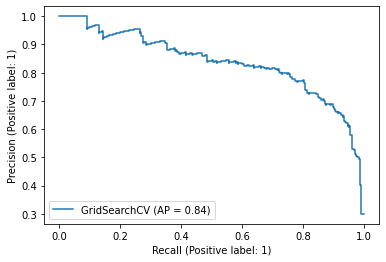

In [47]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import average_precision_score

plt.figure(figsize=(16,10))

disp = plot_precision_recall_curve(clf, test_feature_df, test_true_y)